In [1]:
import os.path
import time

import torch
torch.cuda.empty_cache()

In [2]:
from src.efficentnet_train import data_load,models_train,visualization,utils,generate_dataset,evaluation
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from src.efficentfacenet import face_descriptor
from torchvision import transforms
import pandas as pd



In [3]:
dataset_path = "../dataset/preprocessed"
model_weights_path="../model_weights/training"
train_data_save_path="../training log"
batch_size=8
stop_n_layers=5

In [4]:
train_history=pd.read_csv(train_data_save_path+"/train_data.csv",index_col=False)

In [5]:
train_history

,Train Loss,no train rows,Test Loss,No test rows,Time taken (M),Notes,Date,Time
0,0.280173,100000,0.342320,25000,65.2,remove sigmoid from classifier + input normali...,15/05/2022,23:26:00
1,0.989897,100000,1.000320,25000,60.1,remove sigmoid from classifier + input normali...,16/05/2022,0:27:00
2,1.000000,100000,1.000320,25000,60.2,remove sigmoid from classifier + input normali...,16/05/2022,1:27:00
3,0.173325,50000,0.284327,10000,63.0,remove sigmoid from classifier + input normali...,16/05/2022,19:28:00
4,0.243919,50000,0.281481,10000,60.0,remove sigmoid from classifier + input normali...,16/05/2022,20:28:00
...,...,...,...,...,...,...,...,...
88,2.232002,5000,2.013427,1000,5.9,"Classifier -->(1280,256,128)+ full model train...",19/05/2022,18:07:00
89,105.413096,5000,2.000000,1000,5.7,"Classifier -->(1280,256,128)+ full model train...",19/05/2022,18:13:00
90,2.254081,5000,2.374554,1000,4.9,"Classifier -->(1280,256,128)+ full model train...",19/05/2022,18:21:00
91,2.050803,5000,2.000000,1000,4.7,"Classifier -->(1280,256,128)+ full model train...",19/05/2022,18:26:00


In [6]:
# model = face_descriptor.FaceDescriptorModel(download_weights=True, version="efficientnet_b0")
# model = face_descriptor.FaceDescriptorModel(download_weights=True, version="efficientnet_b0")


In [18]:
import torchvision

In [9]:
model = face_descriptor.FaceDescriptorModel(download_weights=True,version="")

In [20]:
model

ConvNeXt(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU()
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)),data_load.Normalize()])

In [8]:
model

NameError: name 'model' is not defined

In [17]:
train_dataset = data_load.FacesDataset(f"{dataset_path}/train", 5000, transform,True)
test_dataset=data_load.FacesDataset(f"{dataset_path}/test", 1000, transform,True)


 100.0 % of the folders processed img dict loaded in 0.25 m
 100.0 % of the folders processed img dict loaded in 0.06 m


In [8]:
train_dataset.no_of_rows=10000
test_dataset.no_of_rows=2500

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
#load model weights
model.load_local_weights("weights.pt",cuda_weights=True)

FileNotFoundError: [Errno 2] No such file or directory: 'weights.pt'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


313.38013195991516


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

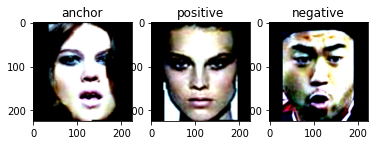

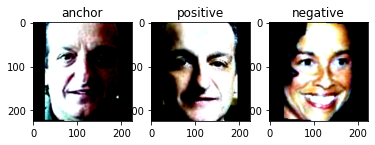

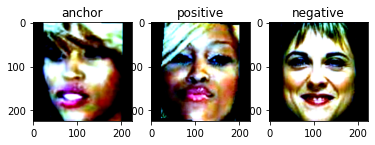

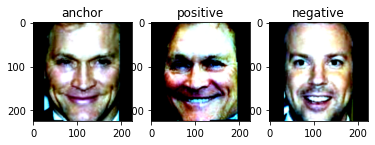

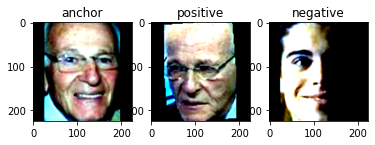

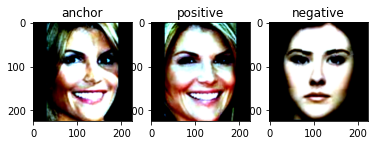

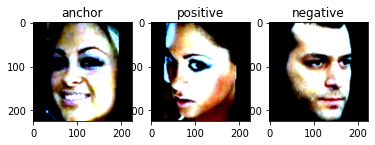

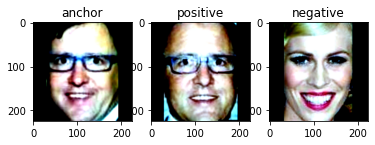

In [19]:
ts=time.time()
a_batch, p_batch, n_batch = next(iter(train_loader))
print(time.time()-ts)
model.eval()
with torch.no_grad():
    for i in range(batch_size):

        fig, ax = plt.subplots(1, 3)

        # anchor_vector=model(a_batch[i].unsqueeze(0)).detach()[0]
        # positive_vector=model(p_batch[i].unsqueeze(0)).detach()[0]
        # negative_vector=model(n_batch[i].unsqueeze(0)).detach()[0]

        ax[0].set_title("anchor")
        ax[0].imshow(a_batch[i].numpy().transpose([1,2,0]))


        ax[1].set_title("positive")
        ax[1].imshow(p_batch[i].numpy().transpose([1,2,0]))



        ax[2].set_title("negative")
        ax[2].imshow(n_batch[i].numpy().transpose([1,2,0]))




        # print(f"anchor vs Positive = {utils.euclidean_distance(anchor_vector.numpy(),positive_vector.numpy())}")
        # print(f"anchor vs negative = {utils.euclidean_distance(anchor_vector.numpy(),negative_vector.numpy())}")

In [20]:
for i in range(stop_n_layers):
  for parm in model.features[i].parameters():
    parm.requires_grad=False


In [21]:
epochs=15
learning_rate=0.001
train_notes="Classifier -->(768,256,128)+ freeze 5 layers  , convnet_small , standaradize input"
last_good_weight="../model_weights/training/convnext_tiny/05_20 12_36 Train_(0.208983) Test_(0.270181).pt"

In [23]:
model.load_local_weights("../model_weights/training/05_19 06_51 Train_(0.298891) Test_(0.357458).pt",True)

RuntimeError: Error(s) in loading state_dict for FaceDescriptorModel:
	Unexpected key(s) in state_dict: "features.1.1.block.0.0.weight", "features.1.1.block.0.1.weight", "features.1.1.block.0.1.bias", "features.1.1.block.0.1.running_mean", "features.1.1.block.0.1.running_var", "features.1.1.block.0.1.num_batches_tracked", "features.1.1.block.1.fc1.weight", "features.1.1.block.1.fc1.bias", "features.1.1.block.1.fc2.weight", "features.1.1.block.1.fc2.bias", "features.1.1.block.2.0.weight", "features.1.1.block.2.1.weight", "features.1.1.block.2.1.bias", "features.1.1.block.2.1.running_mean", "features.1.1.block.2.1.running_var", "features.1.1.block.2.1.num_batches_tracked", "features.2.2.block.0.0.weight", "features.2.2.block.0.1.weight", "features.2.2.block.0.1.bias", "features.2.2.block.0.1.running_mean", "features.2.2.block.0.1.running_var", "features.2.2.block.0.1.num_batches_tracked", "features.2.2.block.1.0.weight", "features.2.2.block.1.1.weight", "features.2.2.block.1.1.bias", "features.2.2.block.1.1.running_mean", "features.2.2.block.1.1.running_var", "features.2.2.block.1.1.num_batches_tracked", "features.2.2.block.2.fc1.weight", "features.2.2.block.2.fc1.bias", "features.2.2.block.2.fc2.weight", "features.2.2.block.2.fc2.bias", "features.2.2.block.3.0.weight", "features.2.2.block.3.1.weight", "features.2.2.block.3.1.bias", "features.2.2.block.3.1.running_mean", "features.2.2.block.3.1.running_var", "features.2.2.block.3.1.num_batches_tracked", "features.3.2.block.0.0.weight", "features.3.2.block.0.1.weight", "features.3.2.block.0.1.bias", "features.3.2.block.0.1.running_mean", "features.3.2.block.0.1.running_var", "features.3.2.block.0.1.num_batches_tracked", "features.3.2.block.1.0.weight", "features.3.2.block.1.1.weight", "features.3.2.block.1.1.bias", "features.3.2.block.1.1.running_mean", "features.3.2.block.1.1.running_var", "features.3.2.block.1.1.num_batches_tracked", "features.3.2.block.2.fc1.weight", "features.3.2.block.2.fc1.bias", "features.3.2.block.2.fc2.weight", "features.3.2.block.2.fc2.bias", "features.3.2.block.3.0.weight", "features.3.2.block.3.1.weight", "features.3.2.block.3.1.bias", "features.3.2.block.3.1.running_mean", "features.3.2.block.3.1.running_var", "features.3.2.block.3.1.num_batches_tracked", "features.4.3.block.0.0.weight", "features.4.3.block.0.1.weight", "features.4.3.block.0.1.bias", "features.4.3.block.0.1.running_mean", "features.4.3.block.0.1.running_var", "features.4.3.block.0.1.num_batches_tracked", "features.4.3.block.1.0.weight", "features.4.3.block.1.1.weight", "features.4.3.block.1.1.bias", "features.4.3.block.1.1.running_mean", "features.4.3.block.1.1.running_var", "features.4.3.block.1.1.num_batches_tracked", "features.4.3.block.2.fc1.weight", "features.4.3.block.2.fc1.bias", "features.4.3.block.2.fc2.weight", "features.4.3.block.2.fc2.bias", "features.4.3.block.3.0.weight", "features.4.3.block.3.1.weight", "features.4.3.block.3.1.bias", "features.4.3.block.3.1.running_mean", "features.4.3.block.3.1.running_var", "features.4.3.block.3.1.num_batches_tracked", "features.5.3.block.0.0.weight", "features.5.3.block.0.1.weight", "features.5.3.block.0.1.bias", "features.5.3.block.0.1.running_mean", "features.5.3.block.0.1.running_var", "features.5.3.block.0.1.num_batches_tracked", "features.5.3.block.1.0.weight", "features.5.3.block.1.1.weight", "features.5.3.block.1.1.bias", "features.5.3.block.1.1.running_mean", "features.5.3.block.1.1.running_var", "features.5.3.block.1.1.num_batches_tracked", "features.5.3.block.2.fc1.weight", "features.5.3.block.2.fc1.bias", "features.5.3.block.2.fc2.weight", "features.5.3.block.2.fc2.bias", "features.5.3.block.3.0.weight", "features.5.3.block.3.1.weight", "features.5.3.block.3.1.bias", "features.5.3.block.3.1.running_mean", "features.5.3.block.3.1.running_var", "features.5.3.block.3.1.num_batches_tracked", "features.6.4.block.0.0.weight", "features.6.4.block.0.1.weight", "features.6.4.block.0.1.bias", "features.6.4.block.0.1.running_mean", "features.6.4.block.0.1.running_var", "features.6.4.block.0.1.num_batches_tracked", "features.6.4.block.1.0.weight", "features.6.4.block.1.1.weight", "features.6.4.block.1.1.bias", "features.6.4.block.1.1.running_mean", "features.6.4.block.1.1.running_var", "features.6.4.block.1.1.num_batches_tracked", "features.6.4.block.2.fc1.weight", "features.6.4.block.2.fc1.bias", "features.6.4.block.2.fc2.weight", "features.6.4.block.2.fc2.bias", "features.6.4.block.3.0.weight", "features.6.4.block.3.1.weight", "features.6.4.block.3.1.bias", "features.6.4.block.3.1.running_mean", "features.6.4.block.3.1.running_var", "features.6.4.block.3.1.num_batches_tracked", "features.7.1.block.0.0.weight", "features.7.1.block.0.1.weight", "features.7.1.block.0.1.bias", "features.7.1.block.0.1.running_mean", "features.7.1.block.0.1.running_var", "features.7.1.block.0.1.num_batches_tracked", "features.7.1.block.1.0.weight", "features.7.1.block.1.1.weight", "features.7.1.block.1.1.bias", "features.7.1.block.1.1.running_mean", "features.7.1.block.1.1.running_var", "features.7.1.block.1.1.num_batches_tracked", "features.7.1.block.2.fc1.weight", "features.7.1.block.2.fc1.bias", "features.7.1.block.2.fc2.weight", "features.7.1.block.2.fc2.bias", "features.7.1.block.3.0.weight", "features.7.1.block.3.1.weight", "features.7.1.block.3.1.bias", "features.7.1.block.3.1.running_mean", "features.7.1.block.3.1.running_var", "features.7.1.block.3.1.num_batches_tracked". 

In [22]:
train_losses=models_train.triplet_loss_train(model,epochs=100,learn_rate=0.001,train_loader=train_loader,test_loader=test_loader,cuda=True,weight_saving_path=model_weights_path,epoch_data_saving_path=train_data_save_path,notes=train_notes)

 epoch 1 [==========] time remaining = 0.0 Avg Train_Loss=1.03213832273
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.99997399972
 epoch 1 train_loss =1.0321382885932922 test_loss=0.9999739127159119
new minimum test loss 0.999973  achieved, model weights saved 
 epoch 2 [==========] time remaining = 0.0 Avg Train_Loss=0.99235792360
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.97469274628
 epoch 2 train_loss =0.9923578706741333 test_loss=0.9746929631233215
new minimum test loss 0.974692  achieved, model weights saved 
 epoch 3 [==========] time remaining = 0.0 Avg Train_Loss=0.75502555956
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.63279635335
 epoch 3 train_loss =0.7550253365278244 test_loss=0.6327966574430466
new minimum test loss 0.632796  achieved, model weights saved 
 epoch 4 [==========] time remaining = 0.0 Avg Train_Loss=0.62367222825
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.59488391784
 epoch 4 train_loss =0.62367

KeyboardInterrupt: 

In [ ]:
train_losses=models_train.triplet_loss_train(model,epochs=100,learn_rate=0.001,train_loader=train_loader,test_loader=test_loader,cuda=True,weight_saving_path=model_weights_path,epoch_data_saving_path=train_data_save_path,notes=train_notes)

In [8]:

saving_path=model_weights_path,epoch_data_saving_path=train_data_save_path,notes=train_notes)

NameError: name 'train_notes' is not defined

In [14]:
model.load_local_weights(model_weights_path+"/05_19 05_11 Train_(0.203699) Test_(0.367653).pt",cuda_weights=True)

In [23]:
features_dict=data_load.get_pic_features_dict(f"{dataset_path}/lfw_prep",model,transform,cuda=True)

 data processed [==========] time remaing=0.000

In [7]:
import numpy as np
type(np.array([[1,2,3]]))

numpy.ndarray

In [24]:
test_data_pd=pd.DataFrame(generate_dataset.generate_testing_data_set_frame(dataset_path+"/lfw_prep",True))

In [32]:
evaluation.model_test(features_dict,test_data_pd,results_path="",threshold=2.8)

 Testing  [==========] time remaining = 0.0 Accuracy =75.701Accuracy now equal --> 75.7005%


(                              Mertic          Value
 0                     processed rows  484414.000000
 1  Model accuracy on Proceed Faces %      75.701000
 2                     False Positive   90385.000000
 3                     False Negative   27325.000000
 4                          precision       0.703913
 5                             recall       0.887180
 6                        fbeta-score       0.378362
 7           avg same person distance       1.622006
 8           avg diff person distance       3.976431
 9                    Model tolerance       2.800000,
                  Actual True  Actual False
 Predicted True        214882         90385
 Predicted False        27325        151822)

In [8]:
evaluation.euclidean_distance(np.array([5,2,3]),[1,5,8])

7.0710678118654755

In [34]:
from datetime import datetime
import os


